In [1]:
import torch 
from torch import nn 
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np 


In [2]:
xDim = 784 # 28* 28 mnist size
hiddenDim = 400
latentDim = 150
batchSize = 100


In [3]:
trainDataSet =MNIST("./",transform=transforms.ToTensor(),train=True,download=True)
testDataSet =MNIST("./",transform=transforms.ToTensor(),train=False,download=True)

trainLoader = DataLoader(dataset=trainDataSet,batch_size=batchSize,shuffle=True)
testLoader = DataLoader(dataset=testDataSet,batch_size=batchSize,shuffle=False)



In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [5]:
class Encoder (nn.Module):
    def __init__(self, input,hidden,latent):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input, hidden),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden, hidden//2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden//2, latent),
            nn.LeakyReLU(0.2),
        )
        self.mean =  nn.Linear(latent,2)
        self.logVar = nn.Linear(latent,2)
    
    def forward(self,x):
        x = self.model(x)
        mean = self.mean(x)
        logVar = self.logVar(x)
        return mean,logVar
    
    



In [15]:
class Decoder (nn.Module):
    def __init__(self, latent, hiddenSize, outputSize):
        super().__init__()
        self.model =  nn.Sequential(
            nn.Linear(2, latent),
            nn.LeakyReLU(0.2),
            nn.Linear(latent,hiddenSize//2),
            nn.LeakyReLU(0.2),
            nn.Linear(hiddenSize//2,outputSize),
        )
    def forward(self, x):
        return torch.sigmoid(self.model(x)
)


In [7]:
class Model(nn.Module):
    def __init__(self, encoder , decoder):
        super(Model, self).__init__()
        self.encoder = encoder 
        self.decoder = decoder
    def reParameterization(self,mean,log):
        std = torch.exp(0.5 * log).to(device)
        eps = torch.randn_like(std).to(device)
        z = mean + eps * std
        return z
    def forward(self, x):
        z = self.encoder(x)
        mean, log = z
        z = self.reParameterization(mean, log)
        xReconstructed = self.decoder(z)
        return xReconstructed ,mean ,log




In [8]:
encoder  = Encoder(xDim,hiddenDim,latentDim).to(device)
decoder  = Decoder(latentDim,hiddenDim,xDim).to(device)
model = Model(encoder,decoder).to(device)



In [9]:
def lossFunc(x,xre,mean,logVar):
    reproductionLoss = nn.functional.binary_cross_entropy(xre,x,reduction='sum')
    KLD =  -0.5 *torch.sum(1+logVar-mean.pow(2)-logVar.exp())
    return reproductionLoss + KLD



In [10]:
optimizer = torch.optim.Adam(model.parameters(),)


In [11]:
epochs = 20 
print("train")
model.train()
for epoch in tqdm(range(epochs),desc="epoch"):
    Loss = 0 
    for batch , (x,_) in tqdm(enumerate(trainLoader),desc="batch"):
        x = x.to(device)
        x = x.reshape(batchSize,xDim)
        optimizer.zero_grad()
        xre , mean,logVar = model(x)
        loss = lossFunc(x,xre,mean,logVar)
        Loss = loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {Loss}")



train


batch: 600it [00:13, 45.50it/s]0:00<?, ?it/s]
epoch:   5%|▌         | 1/20 [00:13<04:10, 13.19s/it]

Epoch 1, Loss: 17022.27734375


batch: 600it [00:11, 53.50it/s]
epoch:  10%|█         | 2/20 [00:24<03:36, 12.04s/it]

Epoch 2, Loss: 16067.6962890625


batch: 600it [00:11, 53.71it/s]
epoch:  15%|█▌        | 3/20 [00:35<03:17, 11.65s/it]

Epoch 3, Loss: 16401.736328125


batch: 600it [00:11, 52.87it/s]
epoch:  20%|██        | 4/20 [00:46<03:04, 11.53s/it]

Epoch 4, Loss: 15248.1220703125


batch: 600it [00:11, 52.26it/s]
epoch:  25%|██▌       | 5/20 [00:58<02:52, 11.52s/it]

Epoch 5, Loss: 14667.953125


batch: 600it [00:11, 52.78it/s]
epoch:  30%|███       | 6/20 [01:09<02:40, 11.47s/it]

Epoch 6, Loss: 15301.2763671875


batch: 600it [00:11, 52.48it/s]
epoch:  35%|███▌      | 7/20 [01:21<02:28, 11.46s/it]

Epoch 7, Loss: 14742.08203125


batch: 600it [00:11, 52.43it/s]
epoch:  40%|████      | 8/20 [01:32<02:17, 11.45s/it]

Epoch 8, Loss: 14854.779296875


batch: 600it [00:11, 52.49it/s]
epoch:  45%|████▌     | 9/20 [01:44<02:05, 11.45s/it]

Epoch 9, Loss: 14177.220703125


batch: 600it [00:11, 54.30it/s]
epoch:  50%|█████     | 10/20 [01:55<01:53, 11.33s/it]

Epoch 10, Loss: 15333.2646484375


batch: 600it [00:11, 51.21it/s]
epoch:  55%|█████▌    | 11/20 [02:06<01:43, 11.45s/it]

Epoch 11, Loss: 14533.6884765625


batch: 600it [00:11, 51.51it/s]
epoch:  60%|██████    | 12/20 [02:18<01:32, 11.51s/it]

Epoch 12, Loss: 14135.681640625


batch: 600it [00:11, 51.72it/s]
epoch:  65%|██████▌   | 13/20 [02:30<01:20, 11.54s/it]

Epoch 13, Loss: 15172.1142578125


batch: 600it [00:11, 52.26it/s]
epoch:  70%|███████   | 14/20 [02:41<01:09, 11.52s/it]

Epoch 14, Loss: 14224.240234375


batch: 600it [00:11, 50.03it/s]
epoch:  75%|███████▌  | 15/20 [02:53<00:58, 11.67s/it]

Epoch 15, Loss: 14575.091796875


batch: 600it [00:11, 51.96it/s]
epoch:  80%|████████  | 16/20 [03:05<00:46, 11.63s/it]

Epoch 16, Loss: 14648.34375


batch: 600it [00:11, 52.26it/s]
epoch:  85%|████████▌ | 17/20 [03:16<00:34, 11.59s/it]

Epoch 17, Loss: 14208.259765625


batch: 600it [00:11, 50.19it/s]
epoch:  90%|█████████ | 18/20 [03:28<00:23, 11.70s/it]

Epoch 18, Loss: 13839.609375


batch: 600it [00:11, 50.47it/s]
epoch:  95%|█████████▌| 19/20 [03:40<00:11, 11.76s/it]

Epoch 19, Loss: 14247.916015625


batch: 600it [00:11, 52.36it/s]
epoch: 100%|██████████| 20/20 [03:52<00:00, 11.60s/it]


Epoch 20, Loss: 14560.1943359375


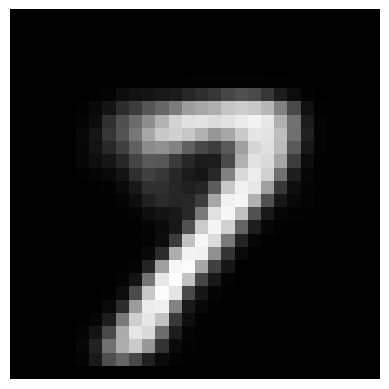

In [17]:
def generateDigit(mean,var):
    zSample = torch.tensor([mean,var],dtype=torch.float32).to(device)
    with torch.inference_mode():
        xDecoded = model.decoder(zSample)
        digit = xDecoded.detach().cpu().reshape(28,28)
    plt.imshow(digit,cmap='gray')
    plt.axis('off')
    plt.show()

generateDigit(-1,.2)


In [13]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


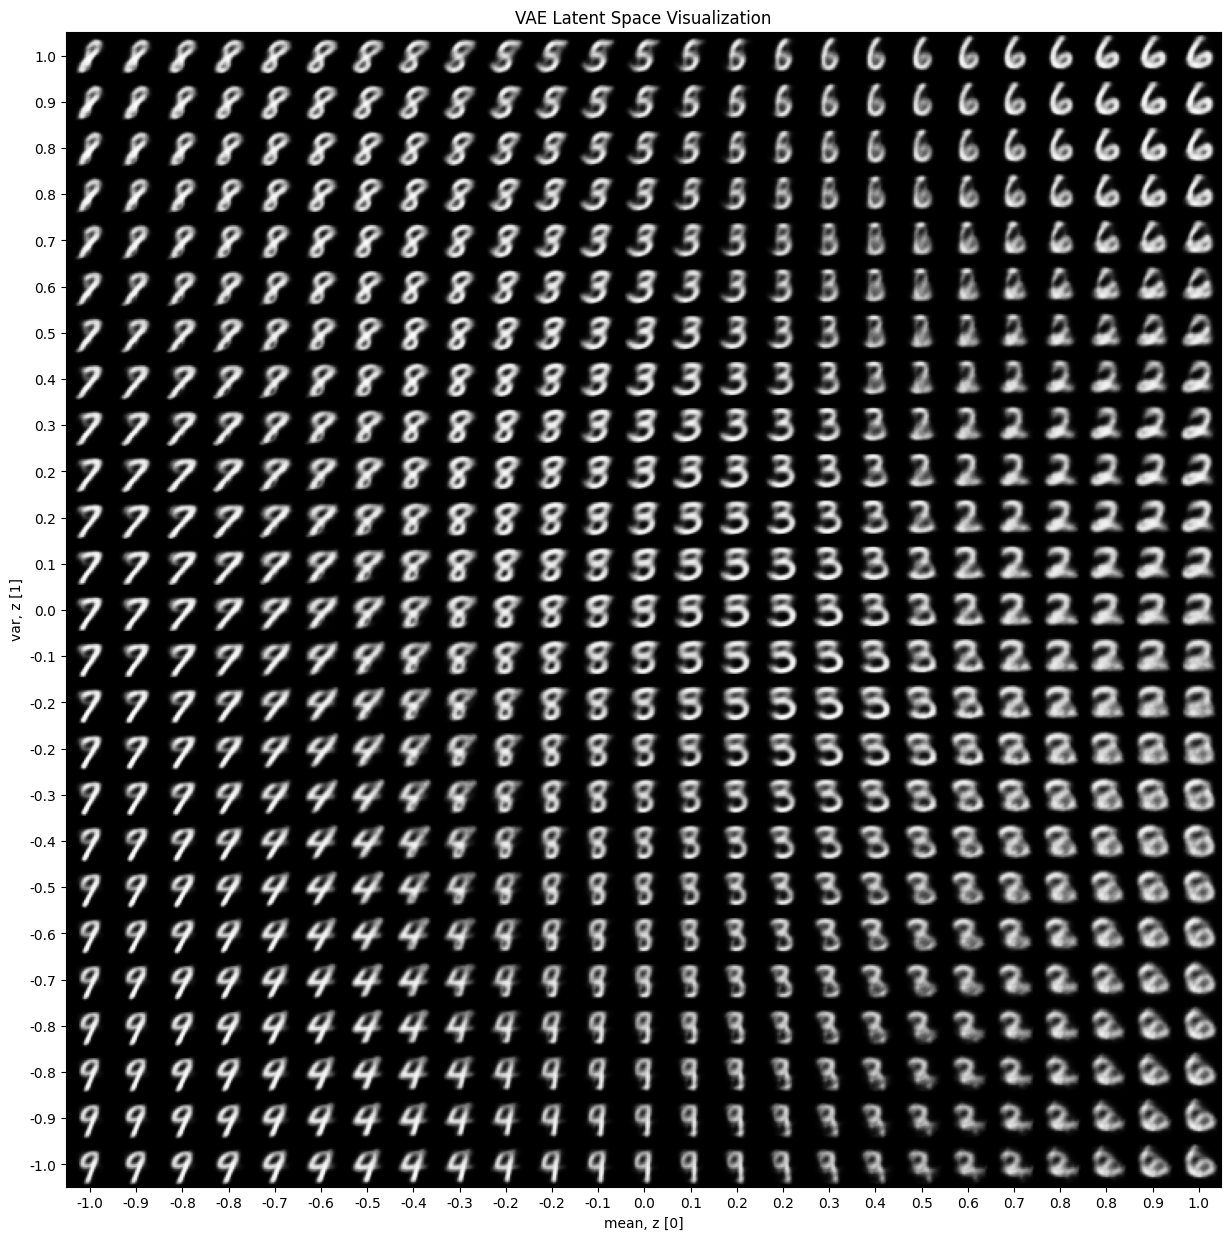

In [14]:
plot_latent_space(model, scale=1.0)
